<a href="https://colab.research.google.com/github/whistle-hikhi/GAN-with-MNIST-Pytorch/blob/main/GAN_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda'  # image = image.to(device)

batch_size = 128 # trainloader, training loop

noise_dim = 64 # generator model

# optimizer parameters

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables

epochs = 20


# Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T

In [5]:
train_augs = T.Compose([
                        T.RandomRotation((-20, +20)),
                        T.ToTensor() # (h,w,c) -> (c,h,w)

])

In [6]:
trainset = datasets.MNIST('MNIST/', download= True, train = True, transform = train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 213063455.41it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 27599839.10it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 63989224.52it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21357095.03it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



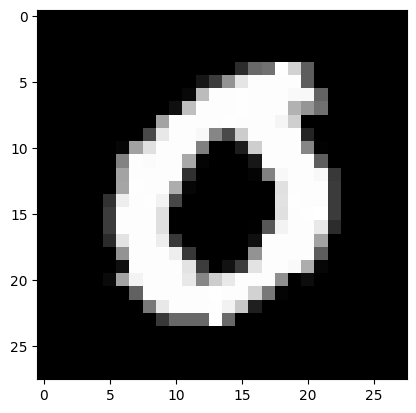

In [9]:
image, label = trainset[8000]
plt.imshow(image.squeeze(), cmap = 'gray')

In [10]:
print(f'Total images present in trainset are: {len(trainset)}')

Total images present in trainset are: 60000


# Load dataset into batches

In [11]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [12]:
trainloader = DataLoader(trainset, batch_size= batch_size, shuffle= True)

In [13]:
print(f'Total no. of batches in trainloader: {len(trainloader)}')

Total no. of batches in trainloader: 469


In [22]:
dataiter = iter(trainloader)
images, _ = next(dataiter)

print(images.shape)

torch.Size([128, 1, 28, 28])


In [20]:
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

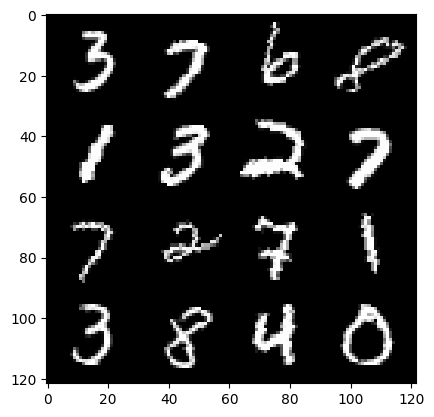

In [23]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [31]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [32]:
class Discriminator(nn.Module):

    def __init__(self):
      super(Discriminator,self).__init__()

      self.block_1 = get_disc_block(1,16,(3,3),2)
      self.block_2 = get_disc_block(16,32,(5,5),2)
      self.block_3 = get_disc_block(32,64,(5,5),2)


      self.flatten = nn.Flatten()
      self.linear = nn.Linear(in_features = 64, out_features = 1)

    def forward(self, images):

        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [36]:
D = Discriminator()
D.to(device)

Discriminator(
  (block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

# Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [41]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block =False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [42]:
class Generator(nn.Module):

    def __init__(self, noise_dim):
      super(Generator,self).__init__()
      self.noise_dim = noise_dim
      self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
      self.block_2 = get_gen_block(256, 128, (4,4),1)
      self.block_3 = get_gen_block(128, 64, (3,3), 2)

      self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

    def forward(self, r_noise_vec):

      # (bs, noise_dim) - > (bs, noise_dim, 1, 1)
      x = r_noise_vec.view(-1, self.noise_dim,1,1)

      x1 = self.block_1(x)
      x2 = self.block_2(x1)
      x3 = self.block_3(x2)
      x4 = self.block_4(x3)

      return x4

In [43]:
G = Generator(noise_dim)
G.to(device)

Generator(
  (block_1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

In [44]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [45]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [46]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [47]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1, D_loss: 0.6853567881624836, G_loss: 0.7052979356190289


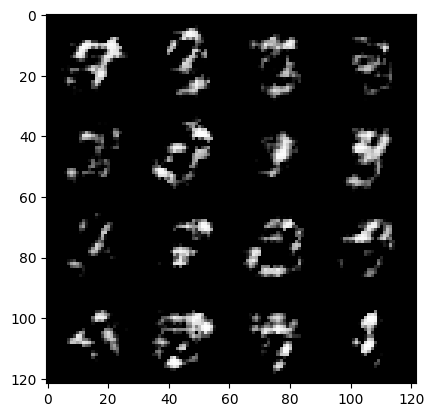

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2, D_loss: 0.6747598274430232, G_loss: 0.7129944738294525


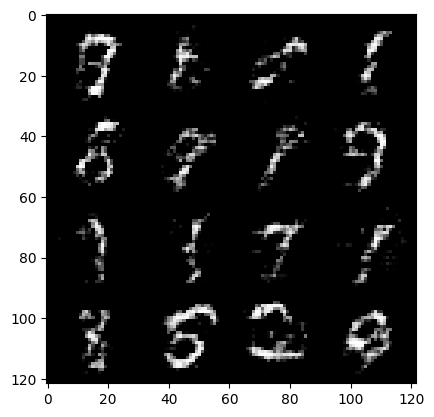

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3, D_loss: 0.6327858703222864, G_loss: 0.7596853724929061


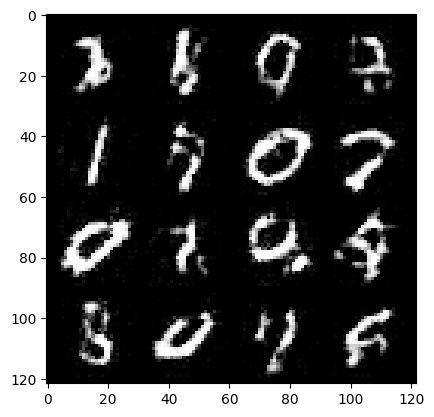

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4, D_loss: 0.6002558277868258, G_loss: 0.8053860403835646


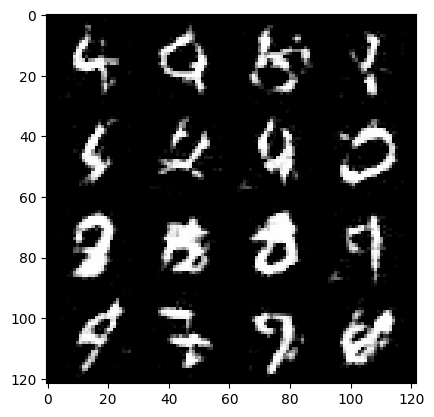

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5, D_loss: 0.5805084663413481, G_loss: 0.8468558292653261


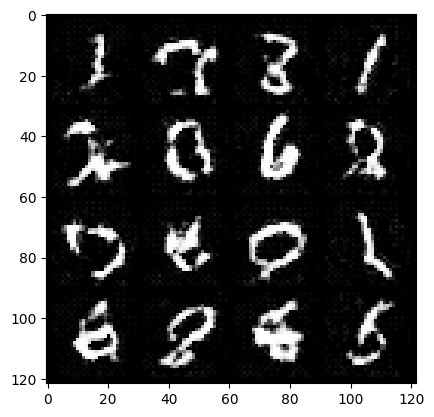

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6, D_loss: 0.5640774033725389, G_loss: 0.8903958833039697


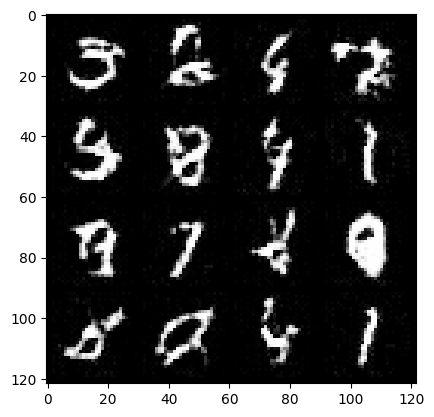

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7, D_loss: 0.5586180290433643, G_loss: 0.9214585345945379


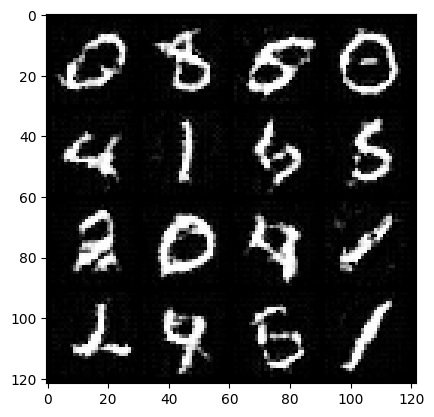

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8, D_loss: 0.5598849994795663, G_loss: 0.936957424891783


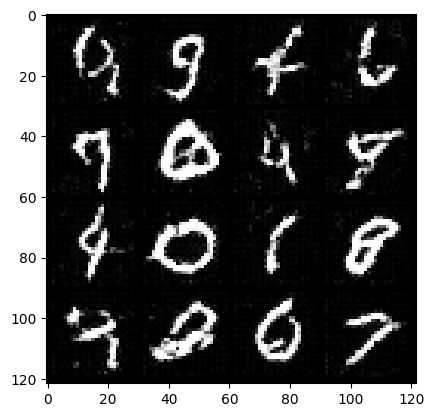

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9, D_loss: 0.5670838967315169, G_loss: 0.9404850013728844


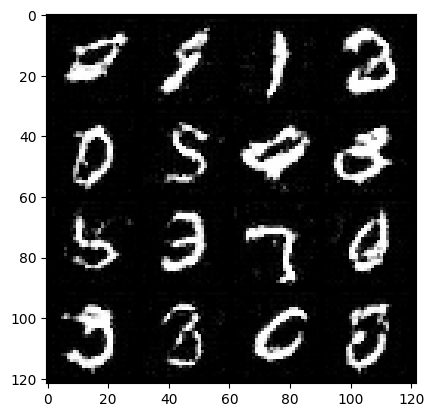

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10, D_loss: 0.5734496041655794, G_loss: 0.9413212064995187


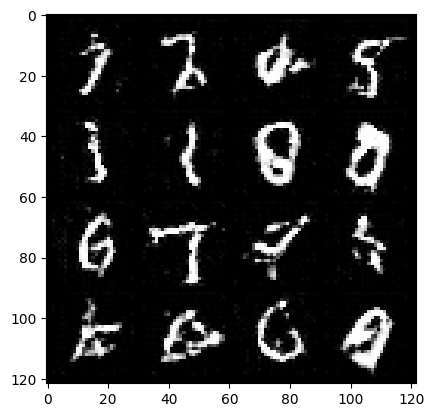

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11, D_loss: 0.5791617502281661, G_loss: 0.9341778606494099


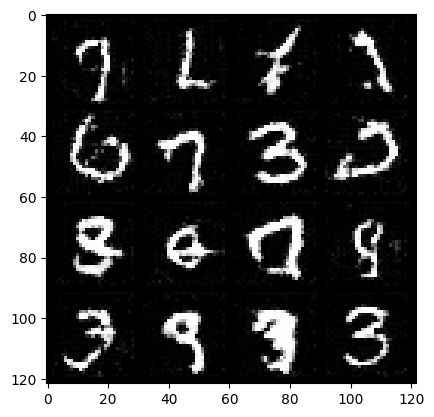

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12, D_loss: 0.5829687651032324, G_loss: 0.9284974443378733


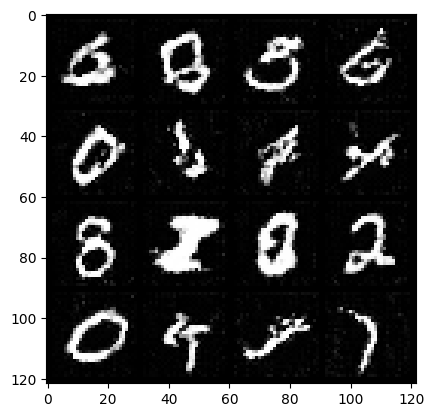

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13, D_loss: 0.5876884272357802, G_loss: 0.9260064524882383


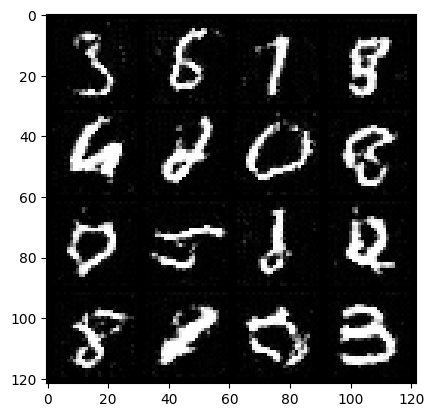

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14, D_loss: 0.5928141047705465, G_loss: 0.9236539423084462


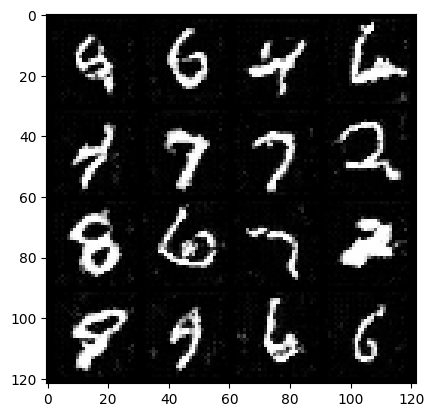

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15, D_loss: 0.5953201519400835, G_loss: 0.9201188839829044


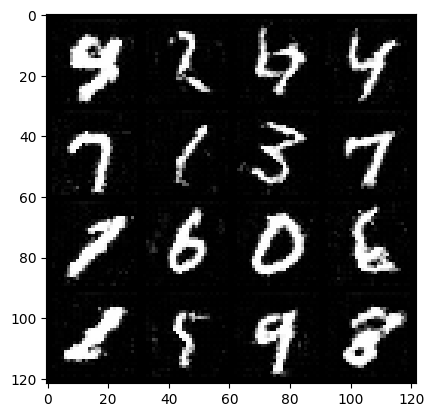

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16, D_loss: 0.5981914727672585, G_loss: 0.9172460063179927


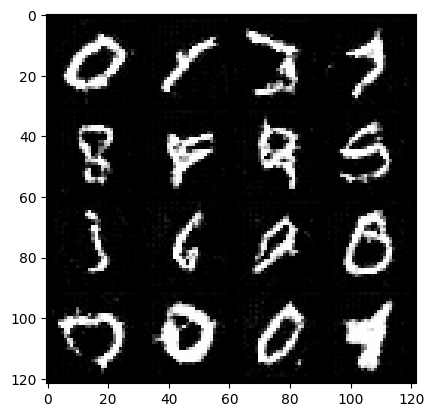

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17, D_loss: 0.5999805620992615, G_loss: 0.9187717466974563


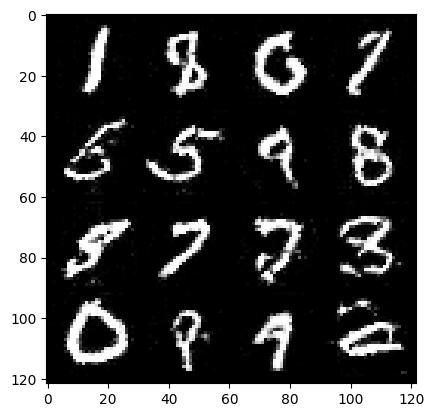

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18, D_loss: 0.6031468232303286, G_loss: 0.9092440033263998


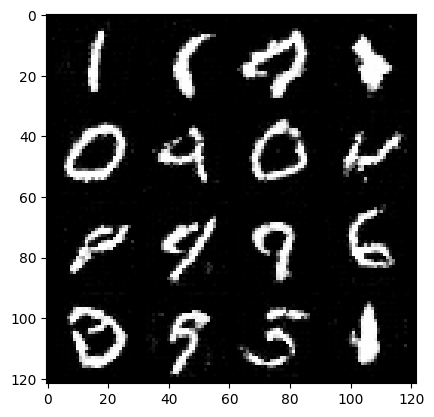

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19, D_loss: 0.6080309367383213, G_loss: 0.9103326040036135


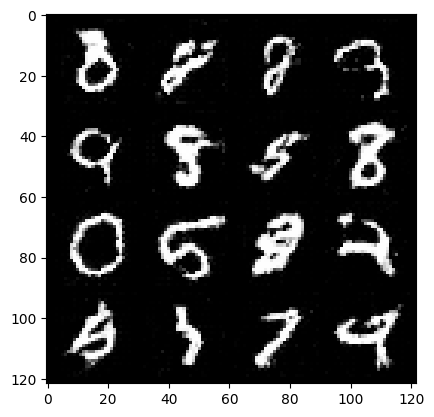

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20, D_loss: 0.6082722849683213, G_loss: 0.9050769383973404


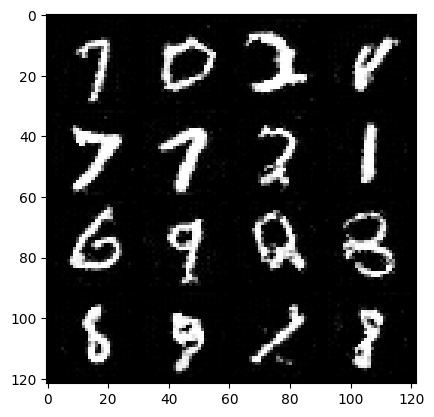

In [48]:
for i in range(epochs):

    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(trainloader):

      real_img = real_img.to(device)
      noise = torch.randn(batch_size, noise_dim, device = device)

      # find loss and update weights for D

      D_opt.zero_grad()

      fake_img = G(noise)
      D_pred = D(fake_img)
      D_fake_loss = fake_loss(D_pred)

      D_pred = D(real_img)
      D_real_loss = real_loss(D_pred)

      D_loss = (D_fake_loss + D_real_loss) / 2

      total_d_loss += D_loss.item()

      D_loss.backward()
      D_opt.step()

      # find loss and update for G

      G_opt.zero_grad()

      noise = torch.randn(batch_size, noise_dim, device= device)

      fake_img = G(noise)
      D_pred = D(fake_img)
      G_loss = real_loss(D_pred)

      total_g_loss += G_loss.item()

      G_loss.backward()
      G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    print(f'Epoch: {i+1}, D_loss: {avg_d_loss}, G_loss: {avg_g_loss}')
    show_tensor_images(fake_img)